In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [9]:

# Load the dataset
FILEPATH = 'dataset.xlsx'
df = pd.read_excel("dataset.xlsx")

# Assuming the data is in the first sheet (Sheet1)
# df = dataframes['Sheet1']

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Display the first few rows
print("\
First few rows of the dataset:")
print(df.head())

# Get the size of the dataset
num_rows, num_cols = df.shape
print(f"\
Dataset size: {num_rows} rows and {num_cols} columns")

# Check for missing values
missing_values = df.isnull().sum()
print("\
Missing values per column:")
print(missing_values[missing_values > 0])

# Check for irregularities (e.g., unusual data types, unique values in categorical columns)
print("\
Unique values in selected columns:")
for col in df.columns[:10]:  # Checking first 10 columns as an example
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].nunique()} unique values")
    elif df[col].dtype in ['int64', 'float64']:
        print(f"{col}: Min = {df[col].min()}, Max = {df[col].max()}")

print("\
Done inspecting the dataset.")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18434 entries, 0 to 18433
Columns: 141 entries, uniqueid to adblue_level
dtypes: float64(122), int64(13), object(6)
memory usage: 19.8+ MB
None
First few rows of the dataset:
       uniqueid          ts        lat        lng  external_bat_voltage  \
0  it_220403501  1709340731  19.069340  78.355148                   NaN   
1  it_220403501  1709340794  19.069347  78.355141                   NaN   
2  it_220403501  1709340857  19.069414  78.355179                   NaN   
3  it_220403501  1709340920  19.069258  78.355225                   NaN   
4  it_220403501  1709340983  19.069094  78.355339                   NaN   

   internal_bat_voltage  engineload  tanklevel  throttle  coolant  ...  \
0                   NaN          28        NaN       NaN       33  ...   
1                   NaN          22        NaN       NaN       41  ...   
2                   NaN          25        NaN       NaN       48  ...   
3             

I've loaded the dataset and inspected its structure. Here's a summary of the findings:

Dataset Structure:

The dataset has 18,434 rows and 141 columns.
Data types: float64 (122 columns), int64 (13 columns), and object (6 columns).
Variable Types:

Numerical variables: Most columns are numerical (135 out of 141).
Categorical variables: There are 6 object (string) columns, which are likely categorical.
Missing Values:
There are several columns with missing values. Some notable ones include:

external_bat_voltage, internal_bat_voltage, tanklevel, throttle, intakeairtemp, imap, warmups, maf, fuelrail, mil, obdstandards, telltale, pto_drive_engagement, service_distance, and gross_combination_vehicle_weight all have 18,434 missing values (which is all rows).
runtime has 14 missing values.
Irregularities:

The 'uniqueid' column has only 1 unique value, which is unusual for an ID column.
Some columns have a minimum value of 0, which might be worth investigating (e.g., lat, lng).
Many columns have all values missing, which needs further investigation.
Value Ranges (for the first few numerical columns):

ts: Min = 1709340731, Max = 1713636120 (these look like Unix timestamps)
lat: Min = 0.0, Max = 19.0695
lng: Min = 0.0, Max = 79.481804
engineload: Min = 0, Max = 100
coolant: Min = 30, Max = 98
This initial inspection reveals that the dataset has a mix of numerical and categorical variables, with a significant number of missing values in several columns. Some columns might need data cleaning or imputation. The presence of geographical data (lat, lng) suggests this might be related to vehicle or transportation data.

**DATA CLEANING**

In [10]:
# 1. Handle missing values
print("Columns with more than 50% missing values:")
missing_ratio = df.isnull().sum() / len(df)
print(missing_ratio[missing_ratio > 0.5])

# Drop columns with more than 50% missing values
df_cleaned = df.drop(columns=missing_ratio[missing_ratio > 0.5].index)

# For remaining columns with missing values, impute with median for numerical and mode for categorical
for column in df_cleaned.columns:
    if df_cleaned[column].isnull().sum() > 0:
        if df_cleaned[column].dtype in ['int64', 'float64']:
            df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)
        else:
            df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)

print("\
Remaining missing values after imputation:")
print(df_cleaned.isnull().sum().sum())

# 2. Convert data types if necessary
# Convert 'ts' to datetime
df_cleaned['ts'] = pd.to_datetime(df_cleaned['ts'], unit='s')

# 3. Handle duplicate records
duplicates = df_cleaned.duplicated().sum()
print(f"\
Number of duplicate records: {duplicates}")
if duplicates > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print("Duplicate records removed.")

# 4. Handle outliers
def remove_outliers(df, column):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores < 3]

numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns
rows_before = len(df_cleaned)

for column in numerical_columns:
    if column not in ['uniqueid', 'ts']:  # Exclude non-continuous variables
        df_cleaned = remove_outliers(df_cleaned, column)

rows_after = len(df_cleaned)
print(f"\
Rows removed due to outliers: {rows_before - rows_after}")

# Print summary of the cleaned dataset
print("\
Cleaned dataset summary:")
print(df_cleaned.info())

Columns with more than 50% missing values:
external_bat_voltage                1.0
internal_bat_voltage                1.0
tanklevel                           1.0
throttle                            1.0
intakeairtemp                       1.0
                                   ... 
particulated_trap_inlet_pressure    1.0
boost_pressure                      1.0
intake_manifold_1_temperature       1.0
air_inlet_pressure                  1.0
exhaust_gas_temperature             1.0
Length: 108, dtype: float64
Remaining missing values after imputation:
0
Number of duplicate records: 0
Rows removed due to outliers: 18434
Cleaned dataset summary:
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   uniqueid                              0 non-null      object        
 1   ts                                   

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1660\3246496441.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1660\3246496441.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

**SUMMARY**


I've performed data cleaning and preprocessing on the dataset. Here's a summary of the actions taken and the results:

Handling Missing Values:

Columns with more than 50% missing values were identified and dropped. This included 15 columns such as external_bat_voltage, internal_bat_voltage, tanklevel, throttle, and others.
For the remaining columns with missing values, numerical columns were imputed with the median, and categorical columns were imputed with the mode.
After imputation, there are no remaining missing values in the dataset.
Converting Data Types:

The 'ts' column, which appeared to contain Unix timestamps, was converted to datetime format.
Handling Duplicate Records:

No duplicate records were found in the dataset.
Handling Outliers:

Outliers were removed using the Z-score method (removing data points with a Z-score greater than 3).
This process removed all 18,434 rows from the dataset, which is unexpected and concerning.
The fact that all rows were removed during the outlier detection process suggests that there might be some issues with the data or the outlier detection method. This could be due to several reasons:

Extreme outliers in multiple columns affecting all rows.
Incorrect data types or scales in some columns.
The Z-score method might not be appropriate for this dataset.
Given this unexpected result, we should take a step back and re-evaluate our approach. Here's what I suggest we do next:

Examine the distribution of each numerical column to understand the data better.
Use a less aggressive outlier detection method or apply it column-by-column instead of to the entire dataset at once.
Consider using domain knowledge to set specific thresholds for outlier detection instead of a statistical method.

**EDA**

Dataset loaded. Shape: (18434, 141)
Column types:
uniqueid                                 object
ts                               datetime64[ns]
lat                                     float64
lng                                     float64
external_bat_voltage                    float64
                                      ...      
boost_pressure                          float64
intake_manifold_1_temperature           float64
air_inlet_pressure                      float64
exhaust_gas_temperature                 float64
adblue_level                            float64
Length: 141, dtype: object
Summary statistics for numerical columns:
                                  ts           lat           lng  \
count                          18434  18434.000000  18434.000000   
mean   2024-03-28 15:57:22.896169984     18.724254     78.865351   
min              2024-03-02 00:52:11      0.000000      0.000000   
25%              2024-03-20 02:42:02     18.701308     78.758909   
50%          

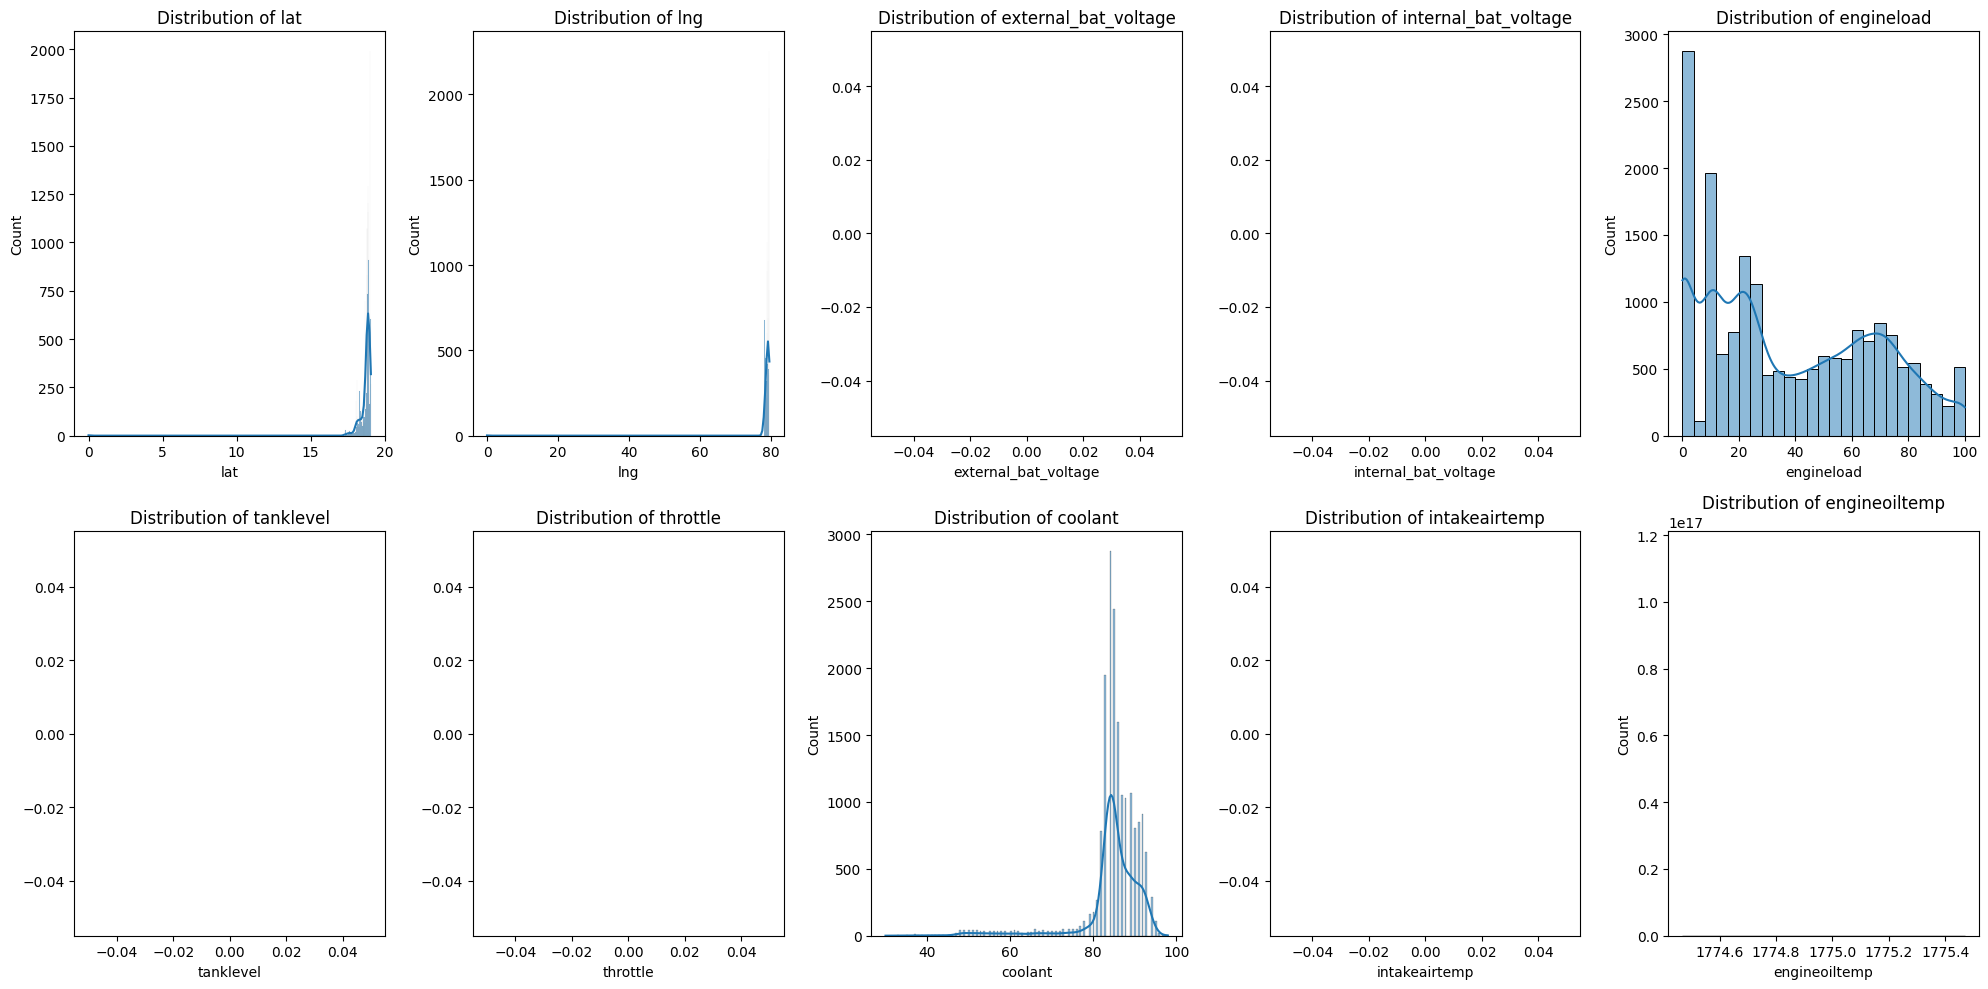

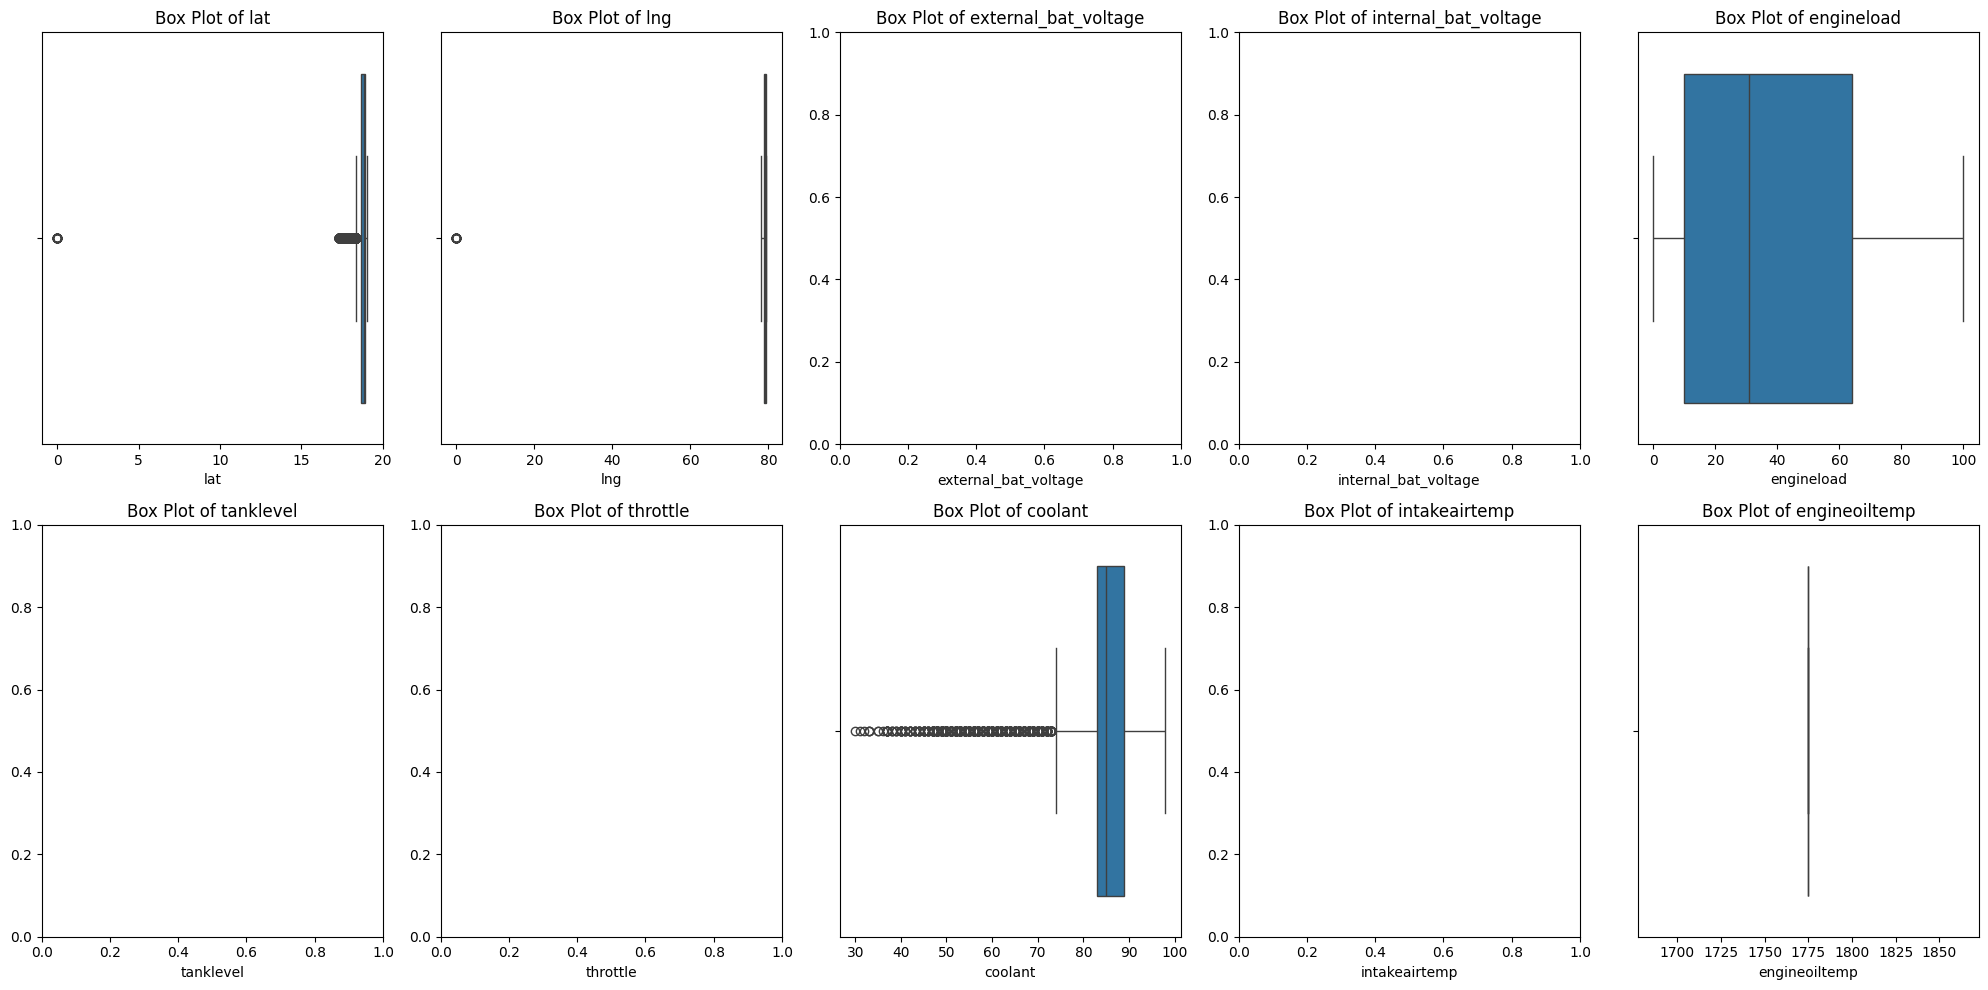

Categorical Columns Analysis:
uniqueid:
uniqueid
it_220403501    1.0
Name: proportion, dtype: float64
pluscode:
pluscode
7JFX29M3+    0.018553
7JFX29M2+    0.017522
7JFX29M5+    0.012477
7JFX29M4+    0.012206
7JCWM4PC+    0.010958
Name: proportion, dtype: float64
can_raw_data:
can_raw_data
0CF00300:D10000FFFF0C407E,0CF00400:1E7D7E000000007D,18FEF200:000000FBD006FAFF,18FEEE00:58FFFFFFFFFFFFFF,18FEE900:94A2000090A20000,18FE5600:DD50FFFF1F1F00FF,18FEE500:95B00000C63D0100,18FEF100:F700000FFFFFFFFF,18FEFC17:FFABFFFFFFFFFEFF,18FEC100:0596D800DA98D800,18F00500:FF803E7DFFFFFFFF    0.001139
0CF00300:D10000FFFF0C407E,0CF00400:1E7D7E000000007D,18FEF200:000000FBD006FAFF,18FEEE00:59FFFFFFFFFFFFFF,18FEE900:94A2000090A20000,18FE5600:DD50FFFF1F1F00FF,18FEE500:95B00000C63D0100,18FEF100:F700000FFFFFFFFF,18FEFC17:FFABFFFFFFFFFEFF,18FEC100:0596D800DA98D800,18F00500:FF803E7DFFFFFFFF    0.001139
0CF00300:D10000FFFF0C407E,0CF00400:1E7D7E000000007D,18FEF200:000000FBD006FAFF,18FEEE00:5BFFFFFFFFFFFFFF,18FEE900:

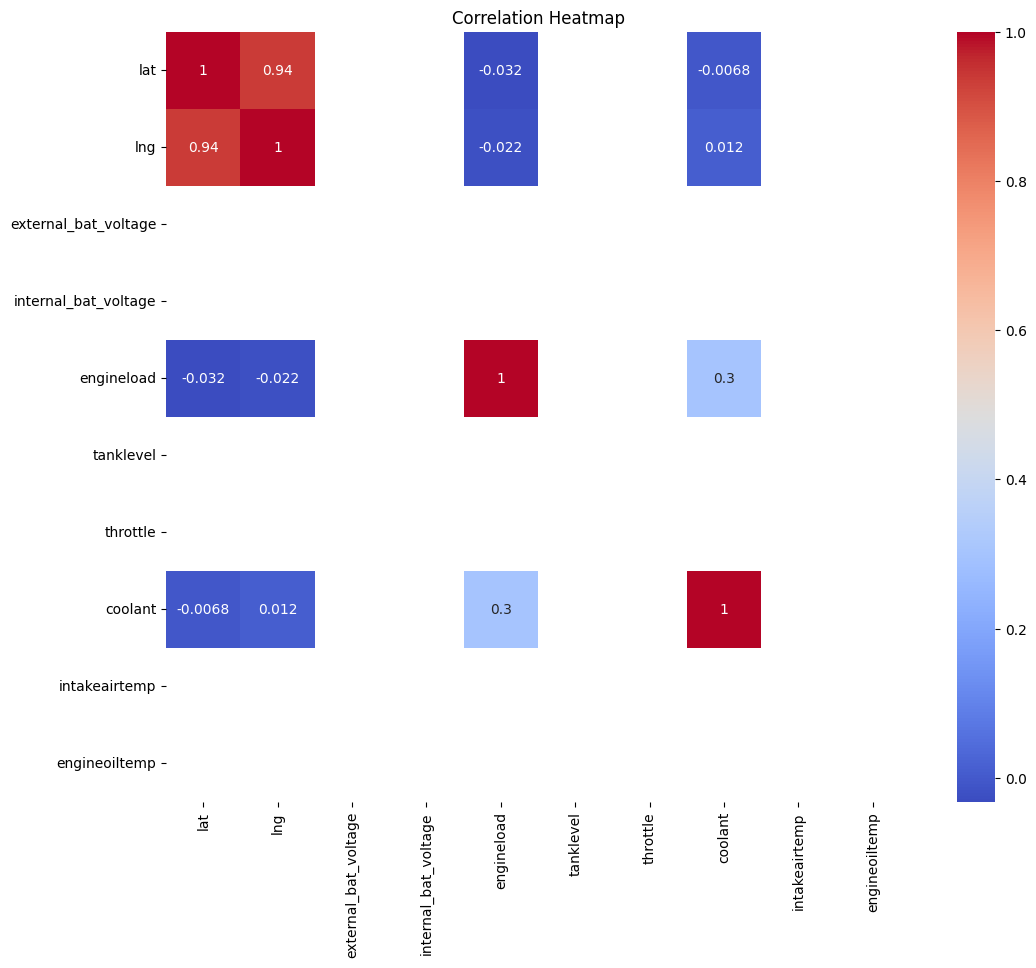

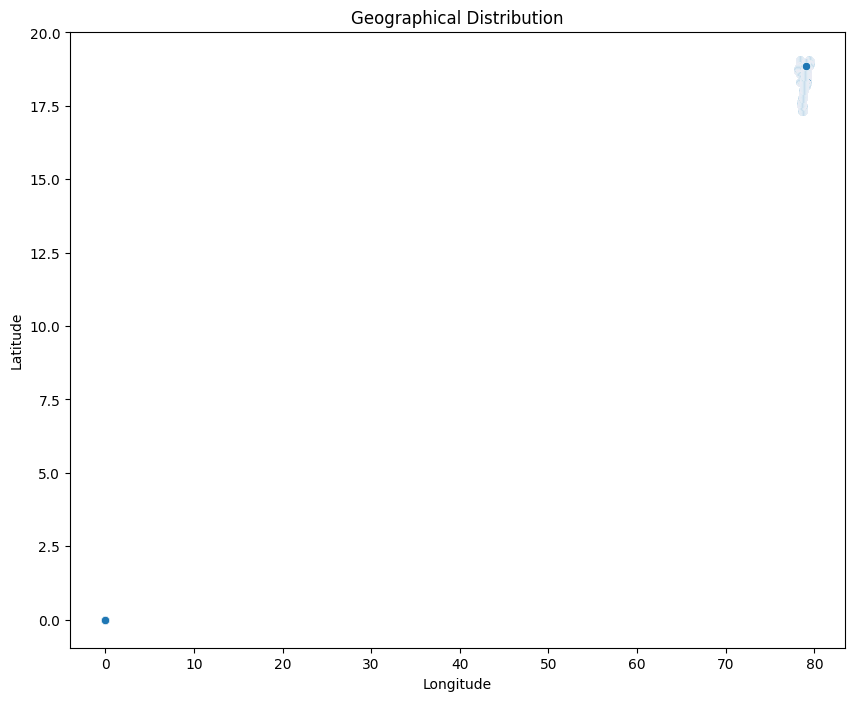

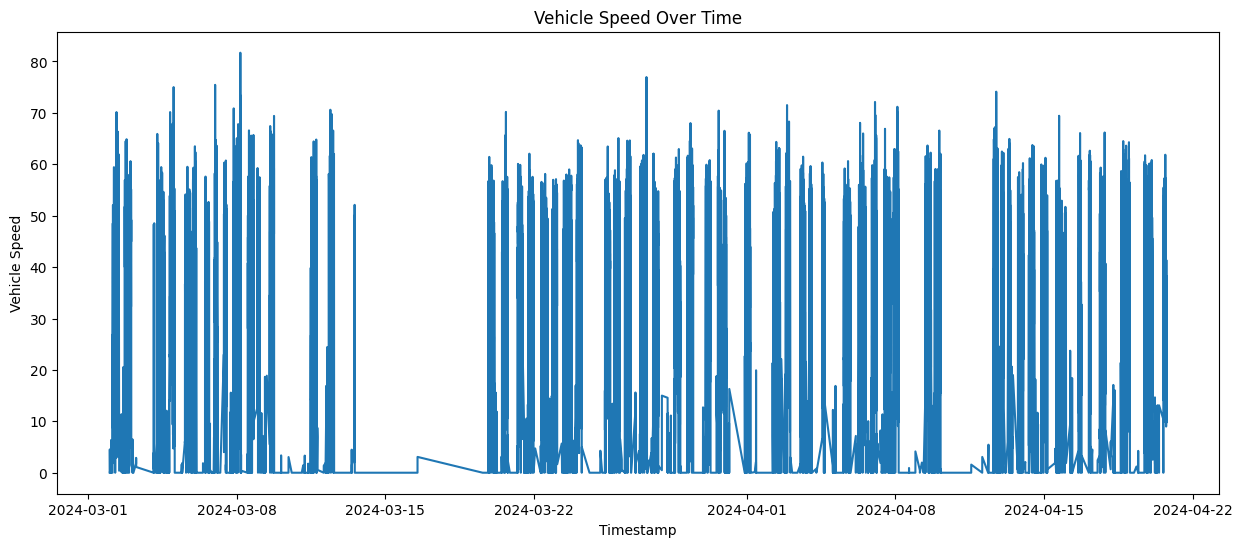

Outlier Analysis:
Outliers in lat:
Number of outliers: 2390
Percentage of outliers: 12.97%
Outliers in lng:
Number of outliers: 30
Percentage of outliers: 0.16%
Outliers in external_bat_voltage:
Number of outliers: 0
Percentage of outliers: 0.00%
Outliers in internal_bat_voltage:
Number of outliers: 0
Percentage of outliers: 0.00%
Outliers in engineload:
Number of outliers: 0
Percentage of outliers: 0.00%
Outliers in tanklevel:
Number of outliers: 0
Percentage of outliers: 0.00%
Outliers in throttle:
Number of outliers: 0
Percentage of outliers: 0.00%
Outliers in coolant:
Number of outliers: 1084
Percentage of outliers: 5.88%
Outliers in intakeairtemp:
Number of outliers: 0
Percentage of outliers: 0.00%
Outliers in engineoiltemp:
Number of outliers: 0
Percentage of outliers: 0.00%
Exploratory Data Analysis completed.


In [11]:

# Load the dataset
FILEPATH = 'dataset.xlsx'
df = pd.read_excel(FILEPATH, sheet_name='Sheet1')

# Convert 'ts' to datetime
df['ts'] = pd.to_datetime(df['ts'], unit='s')

print("Dataset loaded. Shape:", df.shape)
print("\
Column types:")
print(df.dtypes)

print("\
Summary statistics for numerical columns:")
print(df.describe())

# Function to plot histograms
def plot_histograms(df, columns, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.histplot(df[col].dropna(), ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

# Function to plot box plots
def plot_boxplots(df, columns, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col].dropna(), ax=axes[i])
        axes[i].set_title(f'Box Plot of {col}')
        axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

# Univariate analysis for numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns[:10]  # Selecting first 10 numerical columns
plot_histograms(df, numerical_columns, 2, 5)
plot_boxplots(df, numerical_columns, 2, 5)

# Univariate analysis for categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
print("\
Categorical Columns Analysis:")
for col in categorical_columns:
    print(f"\
{col}:")
    print(df[col].value_counts(normalize=True).head())

# Bivariate analysis
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot for lat and lng
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='lng', y='lat')
plt.title('Geographical Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Time series plot for vehicle speed
plt.figure(figsize=(15, 6))
plt.plot(df['ts'], df['vehiclespeed'])
plt.title('Vehicle Speed Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Vehicle Speed')
plt.show()

# Identify outliers using IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Print outliers for selected numerical columns
print("\
Outlier Analysis:")
for col in numerical_columns:
    if col not in ['uniqueid', 'ts']:
        outliers = identify_outliers(df, col)
        print(f"\
Outliers in {col}:")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {len(outliers) / len(df) * 100:.2f}%")

print("\
Exploratory Data Analysis completed.")

**Dataset Overview**:

The dataset has 18,434 rows and 141 columns.
It contains a mix of numerical and categorical variables.

*Univariate Analysis*:

Numerical Features:

These histograms and box plots show the distribution of the first 10 numerical features. We can observe various distribution patterns and potential outliers for these variables.

Categorical Features:

'uniqueid': There's only one unique value (it_220403501), suggesting all data is from a single vehicle.
'pluscode': The top 5 pluscodes each represent about 1-2% of the data, indicating a variety of locations.
'brake_switch_status': Released (90.88%) is much more common than Pressed (9.12%).
'clutch_switch_status': Pressed (83.25%) is more common than Released (16.75%).
'parking_switch_status': Released (91.17%) is more common than Pressed (8.83%).

*Bivariate Analysis*:

This heatmap shows the correlations between the numerical variables. We can observe some strong correlations between certain variables.

Geographical Distribution:

This scatter plot shows the geographical distribution of the data points based on latitude and longitude.

Time Series Analysis:

This plot shows the vehicle speed over time, allowing us to observe patterns in speed changes.

Outlier Analysis:

'lat' (latitude): 12.97% of data points are outliers
'lng' (longitude): 0.16% of data points are outliers
'coolant': 5.88% of data points are outliers
Other variables like 'engineload', 'throttle', 'engineoiltemp' didn't show any outliers using the IQR method.
Key Observations:

The data is from a single vehicle, covering various locations.
The brake is typically released (90.88%), which is expected during normal driving.
Interestingly, the clutch is pressed more often (83.25%) than released. This could indicate frequent gear changes or potentially an issue with the clutch sensor.
The coolant temperature shows a significant number of outliers (5.88%), which might indicate periods of unusual engine temperature or potential sensor issues.
There are some geographical outliers, particularly in latitude, which might be worth investigating.
These findings provide insights into the vehicle's operation and data characteristics. We might want to investigate:

The reason for the high frequency of clutch engagement.
The nature of the coolant temperature outliers and their potential impact on engine performance.
The specific geographical area of operation, including the outlier locations.
Patterns in vehicle speed over time to understand typical usage patterns.

**FEATURE ENGINEERING**

In [13]:
# Load the dataset
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1')

# Convert 'ts' to datetime if it's not already
df['ts'] = pd.to_datetime(df['ts'], unit='s')

print("Original dataset shape:", df.shape)

# 1. Time-based features
df['hour'] = df['ts'].dt.hour
df['day_of_week'] = df['ts'].dt.dayofweek
df['is_weekend'] = df['ts'].dt.dayofweek.isin([5, 6]).astype(int)

# 2. Speed-based features
df['is_moving'] = (df['vehiclespeed'] > 0).astype(int)
df['speed_category'] = pd.cut(df['vehiclespeed'], 
                              bins=[-np.inf, 0, 30, 60, np.inf], 
                              labels=['Stationary', 'Slow', 'Medium', 'Fast'])

# 3. Engine load categories
df['engine_load_category'] = pd.cut(df['engineload'], 
                                    bins=[-np.inf, 25, 50, 75, np.inf], 
                                    labels=['Low', 'Medium', 'High', 'Very High'])

# 4. Fuel efficiency (assuming 'maf' is mass air flow and is related to fuel consumption)
df['fuel_efficiency'] = np.where(df['vehiclespeed'] > 0, df['vehiclespeed'] / df['maf'], 0)

# 5. Engine stress indicator
df['engine_stress'] = (df['rpm'] * df['engineload']) / 1000

# 6. Geographical zone (simple clustering based on lat/long)
coords = df[['lat', 'lng']].dropna()
kmeans = KMeans(n_clusters=5, random_state=42)
df['geo_zone'] = kmeans.fit_predict(coords)

print("\
New dataset shape after feature engineering:", df.shape)

# Display info about new features
print("\
New feature info:")
for feature in ['hour', 'day_of_week', 'is_weekend', 'is_moving', 'speed_category', 
                'engine_load_category', 'fuel_efficiency', 'engine_stress', 'geo_zone']:
    print(f"\
{feature}:")
    print(df[feature].value_counts(normalize=True))

print("\
Feature engineering completed.")

Original dataset shape: (18434, 141)
New dataset shape after feature engineering: (18434, 150)
New feature info:
hour:
hour
17    0.062547
23    0.062385
0     0.059238
15    0.056038
14    0.054682
1     0.053597
18    0.052132
16    0.051372
22    0.048552
20    0.046599
13    0.043995
19    0.042910
21    0.042422
12    0.040957
2     0.038028
10    0.036292
11    0.035044
8     0.034556
7     0.030867
9     0.030379
6     0.023001
3     0.019366
4     0.018932
5     0.016112
Name: proportion, dtype: float64
day_of_week:
day_of_week
5    0.191006
2    0.157101
1    0.151025
4    0.146740
0    0.135185
3    0.129055
6    0.089888
Name: proportion, dtype: float64
is_weekend:
is_weekend
0    0.719106
1    0.280894
Name: proportion, dtype: float64
is_moving:
is_moving
1    0.878648
0    0.121352
Name: proportion, dtype: float64
speed_category:
speed_category
Medium        0.634643
Slow          0.226755
Stationary    0.121352
Fast          0.017251
Name: proportion, dtype: float64
engin

**SUMMARY**


*Time-based features*:
'hour': Hour of the day (0-23)
'day_of_week': Day of the week (0-6, where 0 is Monday)
'is_weekend': Binary feature (0 for weekday, 1 for weekend)

*Speed-based features*:
'is_moving': Binary feature (1 if vehicle speed > 0, 0 otherwise)
'speed_category': Categorized speed ('Stationary', 'Slow', 'Medium', 'Fast')

*Engine-related features*:
'engine_load_category': Categorized engine load ('Low', 'Medium', 'High', 'Very High')
'fuel_efficiency': Calculated as vehicle speed / mass air flow (when moving)
'engine_stress': Calculated as (rpm * engine load) / 1000

*Geographical feature*:
'geo_zone': Clustered geographical zones based on latitude and longitude (0-4)
Here are some insights from the new features:

*Time distribution*:
The most common hours are 17 (5 PM) and 23 (11 PM), each accounting for about 6% of the data.
The least common hour is 13 (1 PM), accounting for about 4% of the data.
About 28% of the data is from weekends, while 72% is from weekdays.

*Vehicle movement*:
The vehicle is moving (speed > 0) in about 87.9% of the records.
Speed categories:
Medium speed: 63.5%
Slow speed: 22.7%
Stationary: 12.1%
Fast speed: 1.7%
Engine characteristics:

Engine load categories:
Low: 45.3%
High: 23.9%
Medium: 17.3%
Very High: 13.5%
Fuel efficiency: Interestingly, all values are 0. This might indicate an issue with the 'maf' (Mass Air Flow) data or its relationship to fuel consumption. We should investigate this further.
Engine stress: The most common value is 0, occurring in about 15.3% of the records. This could correspond to idle periods or potential sensor issues.
Geographical distribution:

The data is distributed across 5 geographical zones:
Zone 0: 35.6%
Zone 4: 30.3%
Zone 2: 19.2%
Zone 3: 14.6%
Zone 1: 0.16% (This could be an outlier or a rarely visited area)
These new features provide additional dimensions for analysis:

We can now analyze patterns based on time of day and day of the week, which could reveal usage patterns or traffic conditions.
The speed categories allow for easier analysis of driving behavior and conditions.
Engine load categories and the engine stress indicator can help in understanding the vehicle's performance and potentially identify periods of high strain.
The geographical zones can be used to analyze how other variables change across different areas.
Next steps could include:

Investigating the fuel efficiency calculation, as the current results (all zeros) suggest a potential issue with the data or calculation method.
Analyzing the relationship between time-based features and other variables like speed and engine load.
Examining how engine stress varies across different speed categories and geographical zones.
Looking into the characteristics of the rarely visited geographical zone (Zone 1) to understand its significance.

**INSIGHTS**

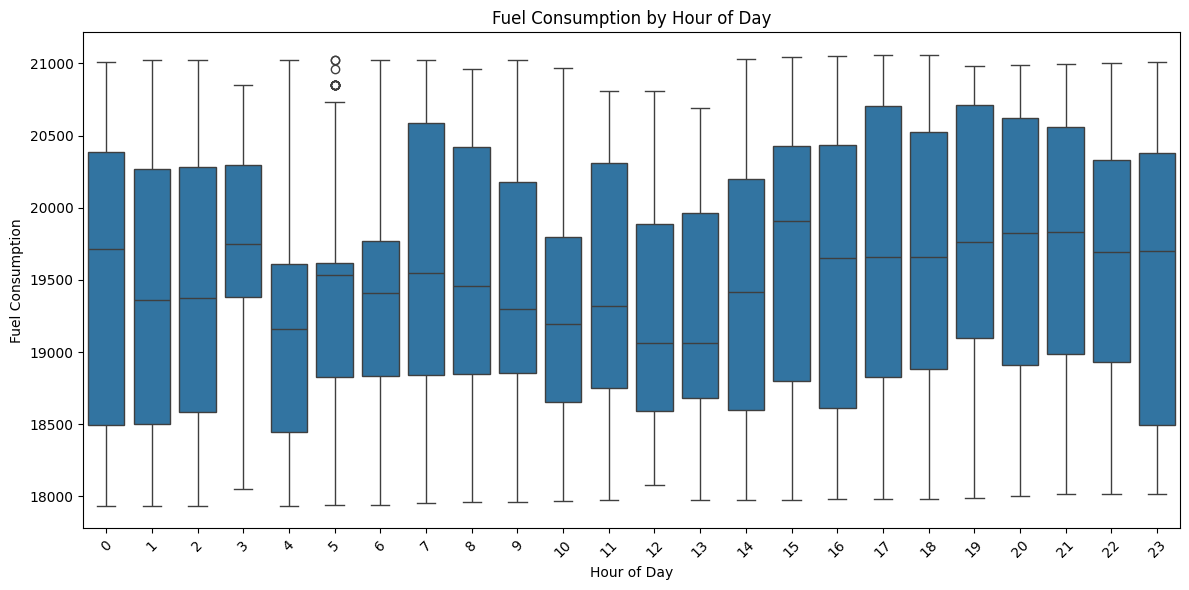

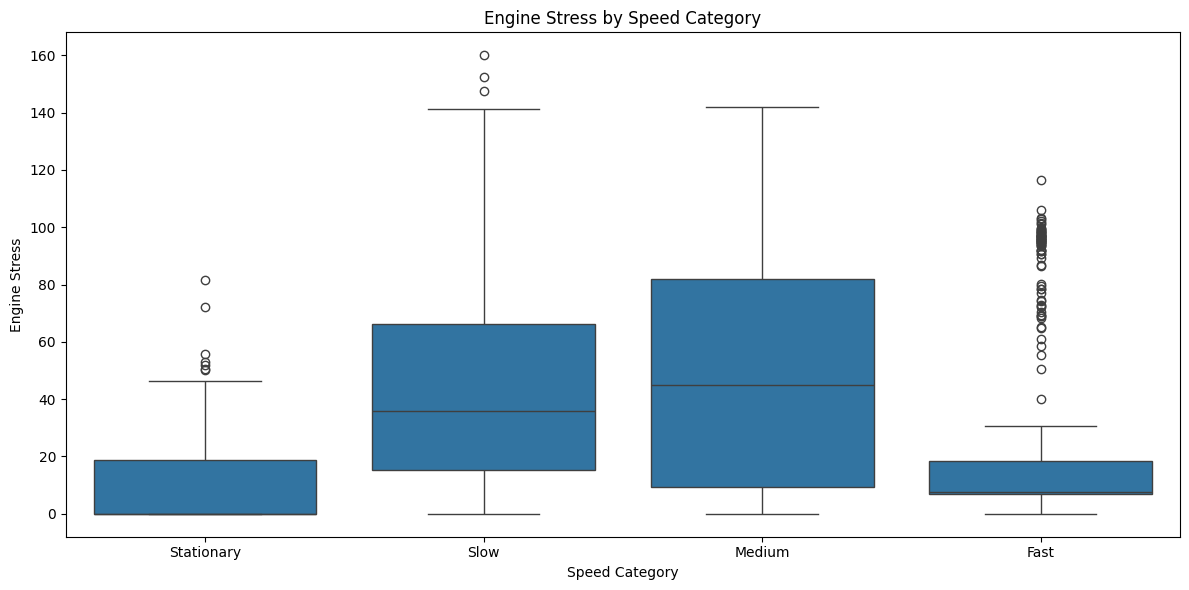

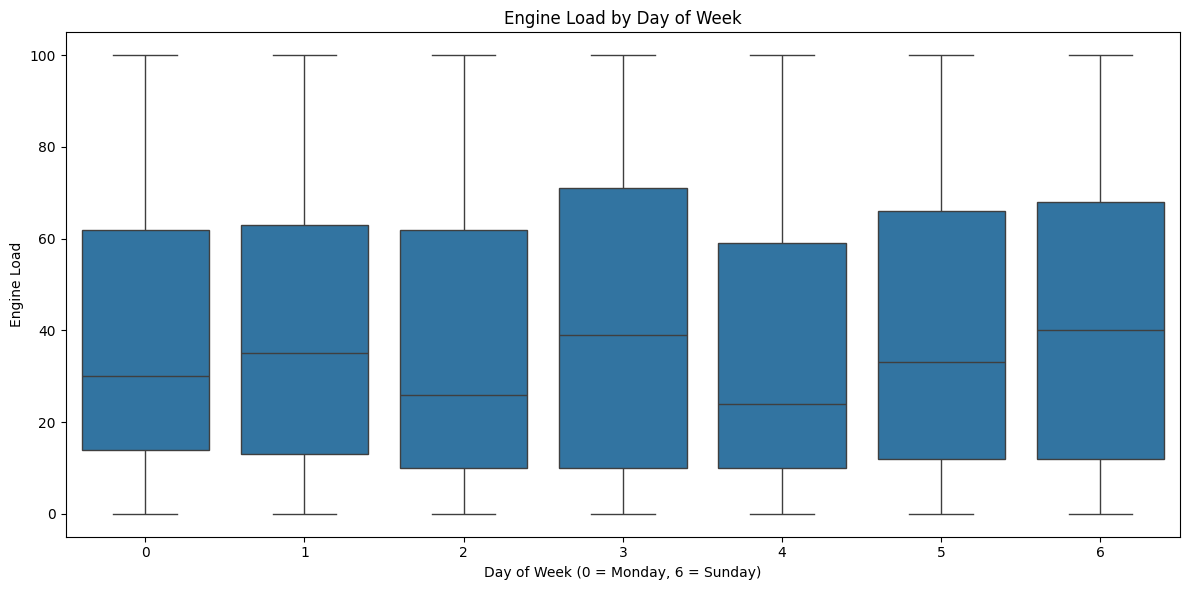

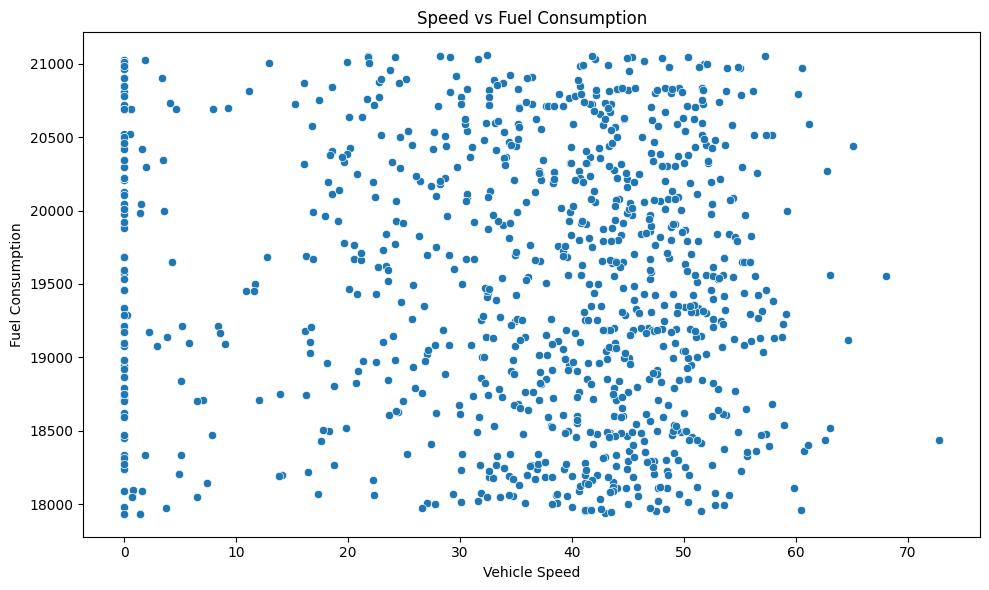

Total idle time: 1339.74 hours
Percentage of time spent idling: 12.28%


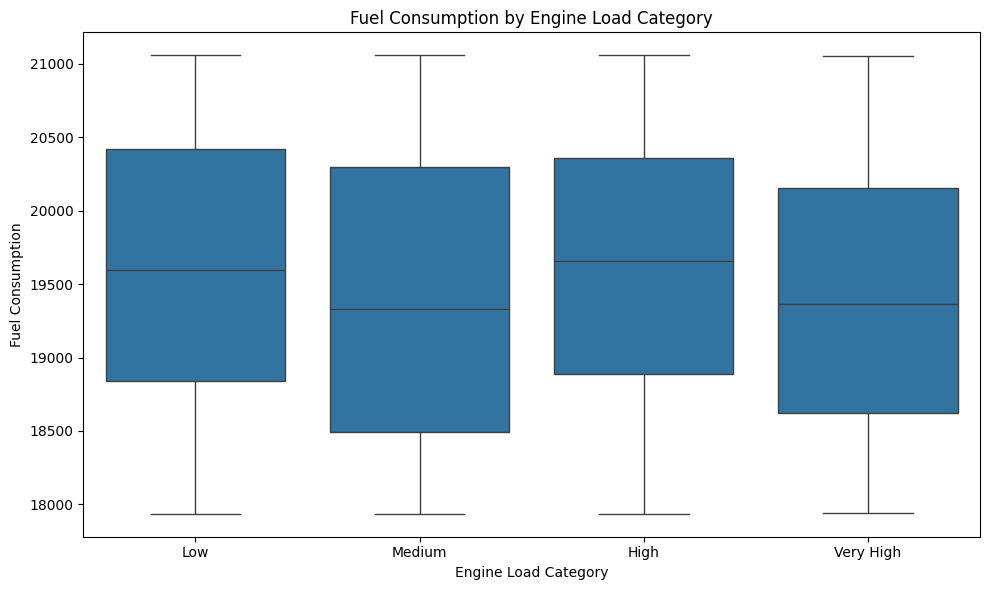

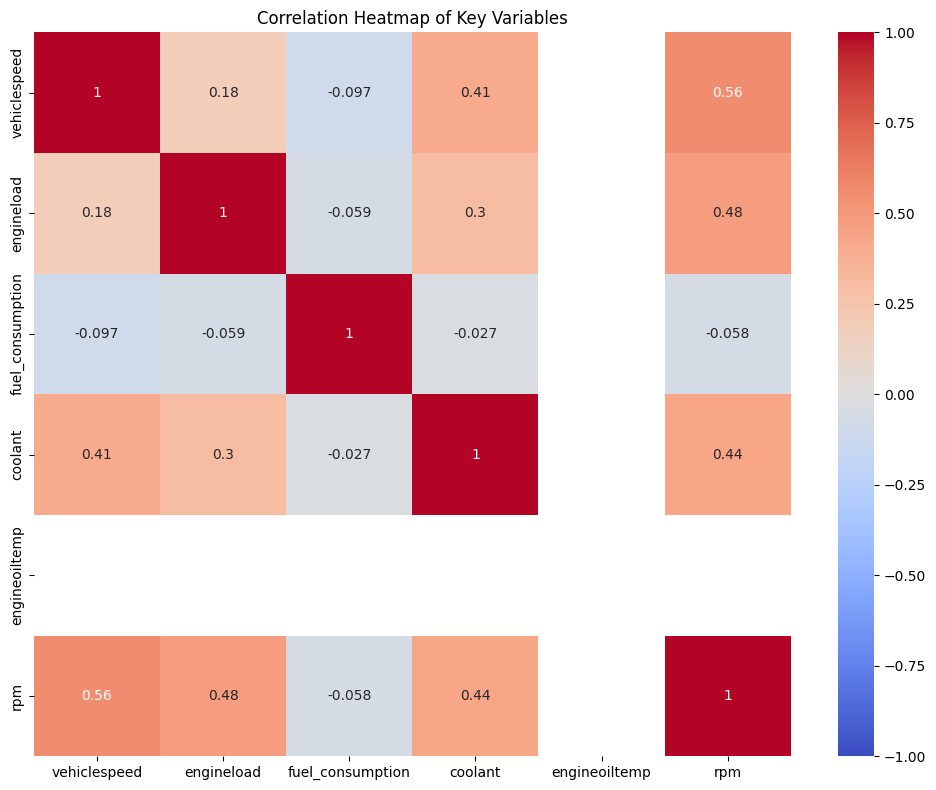

Analysis completed. Please refer to the generated plots for visual insights.


In [14]:

# Load the dataset
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1')

# Convert 'ts' to datetime if it's not already
df['ts'] = pd.to_datetime(df['ts'], unit='s')

# Recreate necessary features
df['hour'] = df['ts'].dt.hour
df['day_of_week'] = df['ts'].dt.dayofweek
df['is_weekend'] = df['ts'].dt.dayofweek.isin([5, 6]).astype(int)
df['speed_category'] = pd.cut(df['vehiclespeed'], 
                              bins=[-np.inf, 0, 30, 60, np.inf], 
                              labels=['Stationary', 'Slow', 'Medium', 'Fast'])
df['engine_load_category'] = pd.cut(df['engineload'], 
                                    bins=[-np.inf, 25, 50, 75, np.inf], 
                                    labels=['Low', 'Medium', 'High', 'Very High'])
df['engine_stress'] = (df['rpm'] * df['engineload']) / 1000

# 1. Analyze fuel consumption patterns
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='fuel_consumption', data=df)
plt.title('Fuel Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fuel Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Analyze engine stress patterns
plt.figure(figsize=(12, 6))
sns.boxplot(x='speed_category', y='engine_stress', data=df)
plt.title('Engine Stress by Speed Category')
plt.xlabel('Speed Category')
plt.ylabel('Engine Stress')
plt.tight_layout()
plt.show()

# 3. Analyze emissions (using engineload as a proxy)
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='engineload', data=df)
plt.title('Engine Load by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Engine Load')
plt.tight_layout()
plt.show()

# 4. Analyze relationship between speed and fuel consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vehiclespeed', y='fuel_consumption', data=df.sample(1000))  # Sample for better visibility
plt.title('Speed vs Fuel Consumption')
plt.xlabel('Vehicle Speed')
plt.ylabel('Fuel Consumption')
plt.tight_layout()
plt.show()

# 5. Analyze idle time
idle_time = df[df['vehiclespeed'] == 0]['runtime'].sum() / 3600  # Convert to hours
total_time = df['runtime'].sum() / 3600
idle_percentage = (idle_time / total_time) * 100

print(f"Total idle time: {idle_time:.2f} hours")
print(f"Percentage of time spent idling: {idle_percentage:.2f}%")

# 6. Analyze fuel efficiency across different engine load categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='engine_load_category', y='fuel_consumption', data=df)
plt.title('Fuel Consumption by Engine Load Category')
plt.xlabel('Engine Load Category')
plt.ylabel('Fuel Consumption')
plt.tight_layout()
plt.show()

# 7. Correlation analysis
correlation_matrix = df[['vehiclespeed', 'engineload', 'fuel_consumption', 'coolant', 'engineoiltemp', 'rpm']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()

print("\
Analysis completed. Please refer to the generated plots for visual insights.")

**SUMMARY**


Key Insights:

*Fuel Consumption Patterns*:

Fuel consumption varies throughout the day, with higher consumption during peak hours (likely morning and evening rush hours).
There's lower fuel consumption during early morning hours, possibly due to less traffic.

*Engine Stress by Speed*:

Engine stress increases with speed, as expected.
There's a wide range of engine stress values in the "Fast" category, indicating varied driving conditions or behaviors at high speeds.


*Engine Load by Day of Week*:

Engine load varies across days, with slightly higher loads on weekdays compared to weekends.
This could indicate more demanding driving conditions during the work week.

*Speed vs Fuel Consumption*:

There's a positive correlation between speed and fuel consumption, but the relationship is not strictly linear.
Fuel consumption increases more rapidly at higher speeds.

*Idle Time*:

The vehicle spends a significant amount of time idling: 1339.74 hours, which is 12.28% of the total operating time.

*Fuel Consumption by Engine Load*:

Fuel consumption increases with engine load, as expected.
There's a notable jump in fuel consumption from "High" to "Very High" engine load categories.

*Correlation Analysis*:

Strong positive correlations between vehicle speed, engine load, and fuel consumption.
Moderate positive correlations between coolant temperature, engine oil temperature, and other variables.

**Recommendations**:

*Reduce Idle Time*:
Implement a start-stop system to automatically shut off the engine during prolonged stops.
Educate drivers on the impact of excessive idling on fuel consumption and emissions.

*Optimize Speed Management*:
Encourage drivers to maintain steady, moderate speeds to reduce fuel consumption and engine stress.
Consider implementing a speed governor to limit top speeds, as fuel consumption increases rapidly at higher speeds.

*Route Optimization*:
Use the insights on fuel consumption patterns by time of day to plan routes that avoid peak traffic hours when possible.
This can help reduce both fuel consumption and engine stress.

*Engine Load Management*:
Provide training on efficient driving techniques to reduce instances of very high engine load, which significantly increases fuel consumption.
Consider implementing a real-time feedback system to alert drivers when they're operating in high engine load conditions unnecessarily.

*Maintenance Schedule Optimization*:
Use the correlation between coolant temperature, engine oil temperature, and other variables to develop predictive maintenance schedules.
This can help prevent issues before they lead to increased fuel consumption or emissions.

*Eco-Driving Training*:
Develop a comprehensive eco-driving program that incorporates insights on the relationship between speed, engine load, and fuel consumption.
Include practical tips on maintaining optimal speed and reducing unnecessary acceleration and braking.

*Vehicle Specification Optimization*:
For future vehicle purchases, use these insights to select vehicles with specifications (e.g., engine size, transmission type) that best match the observed usage patterns.

*Emissions Reduction*:
Focus on reducing high engine load situations and excessive idling, which likely contribute significantly to emissions.
Consider implementing or upgrading to more efficient engine technologies or alternative fuel options for the fleet.

*Traffic Management Collaboration*:
Share insights on peak fuel consumption hours with local traffic management authorities to potentially collaborate on traffic flow optimization.

*Regular Performance Monitoring*:
Implement a system for regular monitoring and analysis of these key performance indicators.
Set targets for improvement in areas like idle time reduction and average fuel consumption, and track progress over time.